In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas_bokeh
from bokeh.io import output_notebook, show
from bokeh.resources import INLINE
from bokeh.plotting import figure
output_notebook(INLINE)
# pandas_bokeh.output_notebook()
from geopy.distance import great_circle
import gc, os, pickle, random, time, cmath, re
import geopy
from collections import Counter, defaultdict
from functools import partial
from pathlib import Path

from contextlib import contextmanager
import multiprocessing
import shap

from datetime import datetime
# import librosa
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.model_selection import cross_val_score,cross_val_predict

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.cluster import KMeans

from lightgbm import LGBMClassifier, LGBMRegressor
from category_encoders import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

/home/kevinco27/.local/lib/python3.5/site-packages/pandas_bokeh/__init__.py:24: Warning: Could not define plot method for Pandas DataFrame and Series. Please make sure that Pandas is installed if you wish to use Bokeh as plotting backend for Pandas. 

Exceptions: cannot import name 'CachedAccessor' 
  Warning,


Loading BokehJS ...

In [38]:
def load_df(dataset):
    if 'train' in dataset:
        df = pd.read_csv("../data/{}.csv".format(dataset))
    elif 'test' in dataset:
        df = pd.read_csv("../data/{}.csv".format(dataset))
    return df

print('Download Train and Test Data.\n')
with multiprocessing.Pool() as pool: 
    train, test = pool.map(load_df, ["train", "test"])

def attr_map(train, test):

    train['city'] = train['city'].map({3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
                                       17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'})
    test['city'] = test['city'].map({3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
                                       17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'})
    return train, test

# train, test = attr_map(train, test)

combine = pd.concat([train, test])
target = train['total_price']


Download Train and Test Data.



# 經緯度轉換

In [5]:
#(118.95, -37.46)
X1 = np.matrix([(117.2,-40.01), (119.66,-37.75), (118.95, -37.46)]) #(118.02,-37.93)])
X2 = np.matrix([(120.713287,21.987057), (121.775596, 25.142056), (120.499489, 24.214840)])
T = inv(X1.T * X1) * X1.T * X2
coor_trans_trn = np.matrix(train[['lon', 'lat']])*T
coor_trans_sub = np.matrix(test[['lon', 'lat']])*T
train['lon'] = np.array(coor_trans_trn[:,0]).squeeze()
train['lat'] = np.array(coor_trans_trn[:,1]).squeeze()

test['lon'] = np.array(coor_trans_sub[:,0]).squeeze()
test['lat'] = np.array(coor_trans_sub[:,1]).squeeze()

# Cluster Target Encode

In [3]:
class cluster_target_encoder:
    def __init__(self, nclusters = 3, seed=0):
        self.seed = seed
        self.nclusters = nclusters
        
    def make_encoding(self,df):
        self.encoding = df.groupby('X')['y'].mean()
        
    def fit(self,X,y):
        df = pd.DataFrame(columns=['X','y'], index=X.index)
        df['X'] = X
        df['y'] = y
        self.make_encoding(df)
        clust = KMeans(self.nclusters, random_state=self.seed)
        labels = clust.fit_predict(self.encoding[df['X'].values].values.reshape(-1,1))
        df['labels'] = labels
        self.clust_encoding = df.groupby('X')['labels'].median()
        
    def transform(self,X):
        res = X.map(self.clust_encoding).astype(float)
        return res
    def fit_transform(self,X,y):
        self.fit(X,y)
        return self.transform(X)

In [31]:
# village 2899
# 213
# 609
train['lonlat'] = str(train['lon'] + train['lat']
test['lonlat'] = test['lon'] + test['lat']
cate = 'lonlat'
X_train = train.drop(['total_price'],axis=1)
y_train = np.log1p(train['total_price'])

encoder = cluster_target_encoder(nclusters=2, seed=4)
labels_train = encoder.fit_transform(X_train[cate],train['total_price'])
labels_test = encoder.transform(test[cate])
est = LGBMClassifier()

est.fit(X_train.select_dtypes(include=[np.number]),labels_train)

labels_test[np.isnan(labels_test)] = est.predict(
    test.select_dtypes(include=[np.number]))[np.isnan(labels_test)]

train['labels'] = labels_train
test['labels'] = labels_test

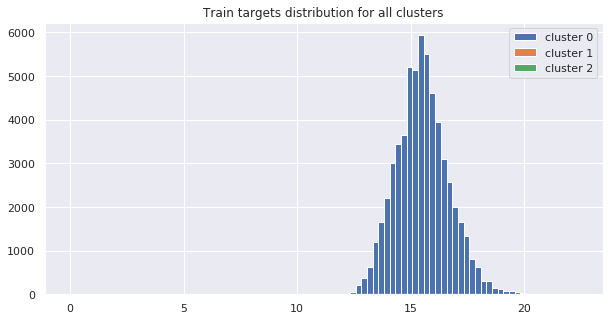

In [32]:
plt.figure(figsize=(10,5))
plt.hist(y_train.values[train['labels']==0],bins=40,label='cluster 0')
plt.hist(y_train.values[train['labels']==1],bins=70,label='cluster 1')
plt.hist(y_train.values[train['labels']==2],bins=70,label='cluster 2')
# plt.hist(y_train.values[train['labels']==3],bins=70,label='cluster 3')
plt.legend()
plt.title('Train targets distribution for all clusters')
# plt.xlim((10,22))
plt.show()

In [34]:
train['lonlat']

0        0        11708\n1        11928\n2        11929...
1        0        11708\n1        11928\n2        11929...
2        0        11708\n1        11928\n2        11929...
3        0        11708\n1        11928\n2        11929...
4        0        11708\n1        11928\n2        11929...
5        0        11708\n1        11928\n2        11929...
6        0        11708\n1        11928\n2        11929...
7        0        11708\n1        11928\n2        11929...
8        0        11708\n1        11928\n2        11929...
9        0        11708\n1        11928\n2        11929...
10       0        11708\n1        11928\n2        11929...
11       0        11708\n1        11928\n2        11929...
12       0        11708\n1        11928\n2        11929...
13       0        11708\n1        11928\n2        11929...
14       0        11708\n1        11928\n2        11929...
15       0        11708\n1        11928\n2        11929...
16       0        11708\n1        11928\n2        11929.

In [6]:
# labels_test[np.isnan(labels_test)].shape()
cross_val_score(
    X = X_train.select_dtypes(include=[np.number]),
    y = labels_train,
    estimator = LGBMClassifier(),
    cv = 5,
    scoring = 'roc_auc')

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

## Target Encoding

In [11]:
# use target encoding to encode two categorical features

target_cate = ['lonlat']
target_num = ['total_price']
for i in target_cate:
    for j in target_num:
        enc = TargetEncoder(cols=[i]).fit(train[i], train[j])

        training_numeric_dataset = enc.transform(train[i], train[j])#.rename(cols={'city':'city_targ'})
        testing_numeric_dataset = enc.transform(test[i])

        training_numeric_dataset.rename(columns={i:i +'_targ_'+j}, inplace=True)
        testing_numeric_dataset.rename(columns={i:i +'_targ_'+j}, inplace=True)

        train[i +'_targ_' + j] = training_numeric_dataset
        test[i +'_targ_' + j] = testing_numeric_dataset
        del training_numeric_dataset, testing_numeric_dataset;
        gc.collect()

In [7]:
dt_today = datetime.today()

def display_shapley_values(feat_importance):
    best_features = feat_importance[["feature", "shap_values"]].groupby("feature")["shap_values"].agg(['mean', 'std']) \
                                                               .sort_values(by="mean", ascending=False).head(40).reset_index()
    best_features.columns = ["feature", "mean shapley values", "err"]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="mean shapley values", y="feature", xerr=best_features['err'], data=best_features)
    plt.title('LightGBM shapley values (avg over folds)')
    plt.savefig('fig/lgbm_shap_{}.png'.format(dt_today.strftime("_%m_%d")))
    plt.tight_layout()
    plt.show()
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('fig/'+'lgbm_{}.png'.format(dt_today.strftime("_%m_%d")))
    
def hit_rate(y_true, y_pred):
    return np.mean(np.array([1 if i <= 0.1 else 0 for i in np.abs((y_pred - y_true)/y_true)]))

def Mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true)/y_true))

def score(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return (np.round(hit_rate(y_true, y_pred), 4)*1e4 + 1 - Mape(y_true, y_pred))

def model(trn, sub, folds):
    print('Official Metrics Test Score: ',score(np.array([1000,1000,1000]), np.array([1300,1100,1050])))
    trn_shape = trn.shape[0]
    feats = [f for f in trn.columns if f not in ['building_id', 'total_price','lonlat']]
    combine = pd.concat([trn[feats], sub[feats]])
    
    average = 0
    for col in feats:
        average += np.array(combine[col].rank(ascending=1))
    average = average/len(feats)
    combine['AVERAGE'] = average
    feats = [f for f in trn.columns if f not in ['building_id', 'total_price','lonlat']]

    trn = combine.iloc[:trn_shape, :]
    sub = combine.iloc[trn_shape:, :]
    
    del combine; gc.collect()
    X = trn[feats]
    y = np.log1p(target)    
    
    sss = KFold(n_splits=folds, shuffle=True, random_state=0)
    feature_importance_df = pd.DataFrame()
    oof_preds = np.zeros(trn.shape[0])
    sub_preds = np.zeros(sub.shape[0])
    
    for fold_, (train_index, test_index) in enumerate(sss.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = LGBMRegressor(n_estimators=100000,
                            learning_rate =  0.01,#0.003,
                            num_leaves=128,                
                            feature_fraction = 0.5, # sub_feature
                            bagging_fraction= 0.8, # subsample
#                             lambda_l2 = 1,
#                             bagging_freq= 5,
#                             min_data_in_leaf= 30,
#                             min_sum_hessian_in_leaf= 10,
#                             tree_learner='serial',
#                             boost_from_average='false',
                            silent=-1,
                            verbose=-1,
                            n_josb=-1)
        
        clf.fit(X_train, y_train, eval_set=[ (X_train, y_train),(X_test, y_test )], 
#                 eval_metric= 'mse', 
#                 categorical_feature  = ['city','town','village'],
                verbose= 7000, early_stopping_rounds= 3000)
        
        y_pred = np.expm1(clf.predict(X_test, num_iteration=clf.best_iteration_))
        print('Fold {}'.format(fold_ + 1), 'Hit-Rate plus MAPE: {}'.format(score(np.expm1(y_test), y_pred)),'\n')
        print('Fold {}'.format(fold_ + 1), 'Hit-Rate {}'.format(hit_rate(np.expm1(y_test), y_pred)),'\n')

        oof_preds[test_index] = y_pred
        sub_preds += clf.predict(sub[feats], num_iteration=clf.best_iteration_) / sss.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
#         fold_importance_df["shap_values"] = abs(shap.TreeExplainer(clf).shap_values(X_test)[:,:sub[feats].shape[1]]).mean(axis=0).T
        fold_importance_df["fold"] = fold_+ 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('Full Hit-Rate plus MAPE score: {}'.format(score(target, oof_preds),'\n'))

#     display_importances(feature_importance_df)
#     display_shapley_values(feature_importance_df)
    return feature_importance_df, oof_preds, sub_preds

feature_importance_df, oof_preds, sub_preds = model(train, test, folds=5)

Official Metrics Test Score:  6667.85
Training until validation scores don't improve for 3000 rounds.
[7000]	training's l2: 0.00225794	valid_1's l2: 0.0391316
[14000]	training's l2: 0.000569897	valid_1's l2: 0.038936
Early stopping, best iteration is:
[16160]	training's l2: 0.000421597	valid_1's l2: 0.0389311
Fold 1 Hit-Rate plus MAPE: 5721.869352953324 

Fold 1 Hit-Rate 0.5720833333333334 

Training until validation scores don't improve for 3000 rounds.
[7000]	training's l2: 0.00224802	valid_1's l2: 0.0382792
[14000]	training's l2: 0.000492445	valid_1's l2: 0.0380552
[21000]	training's l2: 0.000172851	valid_1's l2: 0.0380393
Early stopping, best iteration is:
[18415]	training's l2: 0.000244528	valid_1's l2: 0.0380367
Fold 2 Hit-Rate plus MAPE: 5729.866509609921 

Fold 2 Hit-Rate 0.5729166666666666 

Training until validation scores don't improve for 3000 rounds.
[7000]	training's l2: 0.00228547	valid_1's l2: 0.0371854
[14000]	training's l2: 0.000512907	valid_1's l2: 0.0370885
Early st

```
Fold 1 Hit-Rate plus MAPE: 5759.8696 / 5728.869505539651

Fold 2 Hit-Rate plus MAPE: 5708.866 / 0.57283

Fold 3 Hit-Rate plus MAPE: 5642.8706 /  0.5678

Fold 4 Hit-Rate plus MAPE: 5689.870057726021 

Fold 5 Hit-Rate plus MAPE: 5684.870993463363 
```

# Error Analysis

In [10]:
def hit_rate_all(y_true, y_pred):
    return np.array([1 if i <= 0.1 else 0 for i in np.abs((y_pred - y_true)/y_true)])

train['hit_rate'] = hit_rate_all(target, oof_preds)
train['pred'] = oof_preds
train[train['hit_rate']==0].shape

(60000, 238)

In [14]:
train[train['hit_rate']==0].to_csv('error.csv', index=False)

In [15]:
train[train['hit_rate']==0]['total_price'].describe()

count    2.573700e+04
mean     1.364948e+07
std      6.656837e+07
min      2.299748e+05
25%      2.169636e+06
50%      4.721999e+06
75%      1.067319e+07
max      5.088279e+09
Name: total_price, dtype: float64

In [16]:
train[train['hit_rate']==0]['pred'].describe()

count    2.573700e+04
mean     1.246616e+07
std      4.554454e+07
min      2.076678e+05
25%      2.240361e+06
50%      4.837216e+06
75%      1.057612e+07
max      2.738941e+09
Name: pred, dtype: float64

In [38]:
train[(train['hit_rate']==0)&(train['town']==39)]['city'].unique()
# town 180, 13, 158, 10, 188, 17, 6, 208, 330, 174, 164, 101, 39
# NT, NT, NT, NT, TY, (Taipei KL), KS, NT, KS, (TN TC), NT, (TP TC) , NT, (TP TC),

array([13])

In [207]:
# train[(train['hit_rate']==0)&(train['city']==7)]['town'].value_counts()
# 新北市的town 180, 12,158, 10, 208, 164, 84, 204, 214, 196, 284, 4, 25, 211, 332
# 出包量最大， WHY ?
train[(train['hit_rate']==0)&(train['city']==7)&(train['town']==180)][['']]


180    854
13     772
158    708
10     665
208    577
164    492
84     392
204    389
214    349
196    338
284    321
184    251
4      245
25     152
211    131
332    113
42      61
215     45
236     14
9       14
283     10
307      5
Name: town, dtype: int64

{3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'})
    return train, test

## Data Cleaning 1 town has mutiple city 
- continious data cleaning [ArXiv](http://www.cs.toronto.edu/~mvolkovs/icde14_data_cleaning.pdf)

In [183]:
city_town = []
city_village = []
town_village = []
t1=[];t2=[];t3=[]
for i in combine['village'].unique():
    if len(combine[combine['village']==i]['city'].unique()) != 1:
        city_village.append(i)
    elif len(combine[combine['village']==i]['city'].unique()) > 2:
        t1.append(i)
for i in combine['village'].unique():
    if len(combine[combine['village']==i]['town'].unique()) != 1:
        town_village.append(i)
    elif len(combine[combine['village']==i]['town'].unique()) > 2:
        t2.append(i)
        
for i in combine['town'].unique():
    if len(combine[combine['town']==i]['city'].unique()) != 1:
        city_town.append(i)
    elif len(combine[combine['town']==i]['city'].unique()) > 2:
        t3.append(i)

## 用經緯度距離驗證，人為疏失，or 「同名」

In [145]:

D = {3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'}


In [13]:
combine['CityTownVillage'] = str(combine['city']) + str(combine['town']) + str(combine['village'])
# combine['CityTownVillage_lonlat'] = combine['CityTownVillage'] + combine['lon'] + combine['lat']

# combine['TownVillage'] =  combine['town'] + combine['village']

combine['CityTownVillage_lonlat'].nunique(), combine['CityTownVillage'].nunique(), combine['village'].nunique(), combine['TownVillage'].nunique()

(7248, 1, 2947, 2485)

In [204]:
tt = []
for i in combine['village'].unique():
    if len(combine[combine['village']==i]['CityTownVillage'].unique()) != 1:
        tt.append(i)
print(len(tt))

611


In [171]:
big_range = 'city'
small_range = 'village'
# city_town 
# city_village 
# town_village 
admin_num = random.sample(city_village, k=1)
if big_range == 'city':
    t = combine[combine[small_range]==admin_num[0]][big_range].unique()
    print('City 1: ', D[t[0]])
    print('City 2: ', D[t[1]])

temp = []
for i in range(10):
    combine[combine[small_range]==admin_num][big_range].unique()
    n1 = combine[combine[small_range]==admin_num][big_range].unique()[0]
    n2 = combine[combine[small_range]==admin_num][big_range].unique()[1]
    df = combine[combine[small_range]==admin_num][['city','town','village','lon','lat']]
    df12 = df[df[big_range]==n1].sample(1)
    df14 = df[df[big_range]==n2].sample(1)

    pick_up = (df12['lat'].values, df12['lon'].values)

    drop_off = ( df14['lat'].values, df14['lon'].values,)
    temp.append(round(great_circle(pick_up, drop_off).meters/1000,6))
    print(round(great_circle(pick_up, drop_off).meters/1000,3),'KM')

print('STD:', np.std(temp))


City 1:  Changhua
City 2:  Taipei
127.558 KM
128.364 KM
128.001 KM
128.364 KM
128.364 KM
128.001 KM
128.364 KM
127.558 KM
128.364 KM
128.364 KM
STD: 0.3185113643571322
